In [3]:
from chainer.datasets import get_cifar100
train, test = get_cifar100(withlabel=True)

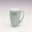

In [23]:
from PIL import Image
Image.fromarray(np.dstack(train[7][0]*255).astype(np.uint8))

In [10]:
#! /usr/bin/env python
# coding : utf-8

import argparse
import numpy as np
from scipy.misc import imsave
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions 


class PreprocessedDataset(chainer.dataset.DatasetMixin):
    def __init__(self, base_image_dataset):
        self.base = base_image_dataset

    def __len__(self):
        return len(self.base)

    def get_example(self, i):
        color_image = self.base[i]
        gray_image = np.ndarray((32, 32), dtype=np.float32)
        for ch in range(3):
            # 輝度を計算し、モノクロ画像を作成
            gray_image = (
                0.298912*color_image[0]
                + 0.586611*color_image[1]
                + 0.114478*color_image[2]
            )
        return gray_image, color_image

class AIC_FC(chainer.Chain):
    def __init__(self, n_units):
        initializer = chainer.initializers.HeNormal()
        super(AIC_FC, self).__init__(
            fc_in = L.Linear(None, n_units),
            bn1 = L.BatchNormalization(n_units),
            fc2 = L.Linear(None, n_units),
            bn2 = L.BatchNormalization(n_units),
            fc_out = L.Linear(None, 32*32*3)
        )

    def __call__(self, x, t):
        y = self.colorize(x)
        loss = F.mean_squared_error(y, t)
        chainer.reporter.report({
            'loss': loss
        })
        return loss

    def colorize(self, x, test=False):
        h = F.elu(self.bn1(self.fc_in(x), test=test))
        h = F.elu(self.bn2(self.fc2(h), test=test))
        y = F.reshape(self.fc_out(h), (h.shape[0], 3, 32, 32))
        return y

class AIC_DC(chainer.Chain):
    def __init__(self, n_ch):
        initializer = chainer.initializers.HeNormal()
        super(AIC_DC, self).__init__(
            cv_in = L.Convolution2D(1, n_ch//4, 4, 2, 1),
            bn1 = L.BatchNormalization(n_ch//4),
            cv1 = L.Convolution2D(n_ch//4, n_ch//2, 4, 2, 1),
            bn2 = L.BatchNormalization(n_ch//2),
            cv2 = L.Convolution2D(n_ch//2, n_ch, 4, 2, 1),
            bn3 = L.BatchNormalization(n_ch),
            cv3 = L.Convolution2D(n_ch, n_ch, 4, 2, 1),
            bn4 = L.BatchNormalization(n_ch),
            dc1 = L.Deconvolution2D(n_ch, n_ch, 4, 2, 1),
            bn5 = L.BatchNormalization(n_ch),
            dc2 = L.Deconvolution2D(n_ch, n_ch//2, 4, 2, 1),
            bn6 = L.BatchNormalization(n_ch//2),
            dc3 = L.Deconvolution2D(n_ch//2, n_ch//4, 4, 2, 1),
            bn7 = L.BatchNormalization(n_ch//4),
            dc_out = L.Deconvolution2D(n_ch//4, 3, 4, 2, 1, outsize=(32, 32))
        )

    def __call__(self, x, t):
        y = self.colorize(x)
        loss = F.mean_squared_error(y, t)
        chainer.reporter.report({
            'loss': loss
        })
        return loss

    def colorize(self, x, test=False):
        # Convolution層に入力するため、ndimが4になるようにreshape
        h = F.reshape(x, (x.shape[0], 1, 32, 32))
        h = F.elu(self.bn1(self.cv_in(h), test=test))
        h = F.elu(self.bn2(self.cv1(h), test=test))
        h = F.elu(self.bn3(self.cv2(h), test=test))
        h = F.elu(self.bn4(self.cv3(h), test=test))
        h = F.elu(self.bn5(self.dc1(h), test=test))
        h = F.elu(self.bn6(self.dc2(h), test=test))
        h = F.elu(self.bn7(self.dc3(h), test=test))
        y = self.dc_out(h)
        return y


def main():
    parser = argparse.ArgumentParser(description='Automatic Image Colorization')
    parser.add_argument('--batchsize', '-b', type=int, default=64,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=30,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--gpu', '-g', type=int, default=0,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the training from snapshot')
    parser.add_argument('--n_ch', '-nc', type=int, default=1024,
                        help='Number of channels')
    parser.add_argument('--n_units', '-nu', type=int, default=0,
                        help='Number of units')
    args = parser.parse_args()
    print('# GPU: {}'.format(args.gpu))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))

    if args.n_units > 0:
        print('# n_units: {}\n'.format(args.n_units))
        model = AIC_FC(args.n_units)
    else:
        print('# n_ch: {}\n'.format(args.n_ch))
        model = AIC_DC(args.n_ch)
    if args.gpu >= 0:
        chainer.cuda.get_device().use()
        model.to_gpu()

    opt = chainer.optimizers.Adam()
    opt.setup(model)

    train, test = chainer.datasets.get_cifar100(withlabel=False)
    test_img = (
        0.298912*test[:64,0]
        + 0.586611*test[:64,1]
        + 0.114478*test[:64,2]
    )
    # 64枚の画像を8x8に並んだ一枚の画像として保存する
    imsave(
        'test.png',
        test[:64]
        .transpose(0, 2, 3, 1)
        .reshape((8, 8, 32, 32, 3))
        .transpose(1, 2, 0, 3, 4)
        .reshape(8*32, 8*32, 3)
    )
    imsave(
        'test_gray.png',
        test_img
        .reshape((8, 8, 32, 32))
        .transpose(1, 2, 0, 3)
        .reshape(8*32, 8*32)
    )
    if args.gpu >= 0:
        test_img = chainer.cuda.to_gpu(test_img)


    dataset = PreprocessedDataset(train)
    iterator = chainer.iterators.MultiprocessIterator(dataset, args.batchsize)

    updater = chainer.training.StandardUpdater(iterator, opt, device=args.gpu)
    trainer = chainer.training.Trainer(updater, (args.epoch, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport([
        'epoch', 'loss', 'elapsed_time'
    ]))
    @chainer.training.make_extension(trigger=(10, 'epoch'))
    def test_model(trainer):
        # 値域を0~1にするため、clipped_reluを通す
        colorized_img = chainer.cuda.to_cpu(F.clipped_relu(model.colorize(test_img, test=True), z=1.0).data)
        imsave(
            'test_colorized{}.png'.format(trainer.updater.epoch),
            colorized_img
            .transpose(0, 2, 3, 1)
            .reshape((8, 8, 32, 32, 3))
            .transpose(1, 2, 0, 3, 4)
            .reshape(8*32, 8*32, 3)
        )
    trainer.extend(test_model)
    trainer.extend(extensions.ProgressBar(update_interval=100))

    trainer.run()

main()

usage: ipykernel_launcher.py [-h] [--batchsize BATCHSIZE] [--epoch EPOCH]
                             [--gpu GPU] [--resume RESUME] [--n_ch N_CH]
                             [--n_units N_UNITS]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\dan\AppData\Roaming\jupyter\runtime\kernel-cbfb9477-0413-43d1-a6a3-9da590d1a735.json


SystemExit: 2

C:\Users\dan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
